# 通过数据增强来处理数据不平衡问题的示例

# 一、简要介绍


> * 训练模型需要数据，但是往往得不到均衡的数据集。数据不均衡，往往很难得到理想的训练效果。然而，数据不均衡是个普遍现象，很多问题本身就决定了它不可能获取到均衡的数据集。  
> * 处理这个问题的基本思路是想办法让每一类数据在训练中都能够有相同的“权重”，比如“采样”、“数据合成”等方法。本质上，就是对原始数据集进行处理，使每一个类别的数据都有足够的数据量来体现其特征，同时在训练中的权重达到均衡，避免模型跑歪。 
> * 还有一个思路，就是通过调整每个类别出错时的权重，也就是让不同类别的出错代价不同，这叫做“加权”。但是难点在于很难合理分配这个权重
> * 这里展示的例子，是通过数据增强的办法，把训练数据每类的样本数量拉齐。这是一个简单的处理不平衡的办法，但测试结果显示是有效的，大约可以把准确率提升1到2个百分点  
> * 本示例所采用的办法，属于“数据合成”

## 解决数据不平衡的办法
![](https://ai-studio-static-online.cdn.bcebos.com/3d182bef8e4f4d44990ab1822742f64197c5f86301c4488daf14211a255d52be)


## 本示例操作流程
![](https://ai-studio-static-online.cdn.bcebos.com/8072fb21f06949988706b6de4dc0c6d9dc06015b9f0146b192364b122b1c5507)


# 二、环境设置

> * 这个示例使用 paddle version:2.1.2

In [1]:
#---导入模块
import paddle
from paddle.vision.transforms import functional as F
from paddle.vision.transforms import RandomRotation
from paddle.io import Dataset
from paddle.vision import transforms
from paddle.static import InputSpec
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import pandas as pd
import cv2
import os
import shutil
import zipfile
import platform
import glob
import random
import datetime
import copy

#---打印paddle 版本
print(f"paddle version:{paddle.__version__}")

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


paddle version:2.1.2


# 三、数据集概览

## 3.1 数据集下载
> * 本案例使用的是柠檬四分类问题数据集，来源于日本广岛Quest2020竞赛（柠檬外观分类竞赛），网址：
> https://signate.jp/competitions/431
  
> * 为方便使用，我复制了一份  
> [https://aistudio.baidu.com/aistudio/datasetdetail/122473](https://aistudio.baidu.com/aistudio/datasetdetail/122473)

## 3.2 数据集概述
> * 该数据集有四个分类，解压出来的 train_images 目录下即是所有训练用的数据样本，为jpg文件格式。  
> * train_images.csv 文件标记了训练数据的分类，共有四个分类：  
>['0:優良', '1:良', '2:加工品', '3:規格外']

## 数据集图片样例
![](https://ai-studio-static-online.cdn.bcebos.com/3a53b58efc454a1bbf3a8d8ba878a73bbc4285cb768e4fce833b522c14ac0bd8)


## 本示例所使用的数据集并不平衡，各个标签对应的图片数量如下图所示![](https://ai-studio-static-online.cdn.bcebos.com/e1fe02bb4fd14c70b6ce7a9caf32fd78678bdcffa0464e5eaa3e38c44e47712d)



## 3.3 解压缩数据
> * 挂载的数据集路径：/home/aistudio/data/data122473/lemon4.zip
> 把它解压到 /data
> * 压缩包里面还有一层压缩包，全部解压出来

In [2]:
#---定义解压函数
def unzip_files(file_path,unzip_path):
    zipFile = zipfile.ZipFile(file_path)
    try:
        for file in zipFile.namelist():
            zipFile.extract(file, unzip_path)
    except:
        pass
    finally:
        zipFile.close()

#zip文件路径
zip_file_path = '/home/aistudio/data/data122473/lemon4.zip'
fd_data = "data/"    #data文件夹

#---定义data目录清理函数，清理data目录,只保留最原始的数据zip文件
def clean_fd_data():
    fd_data_list = os.listdir(fd_data)    #data文件夹下的目录列表
    for fd_data_obj in fd_data_list:    #遍历data文件夹,清理文件
        if fd_data_obj in zip_file_path:continue    #如果在zip_file_path路径中，跳过
        fd_data_sub = os.path.join(fd_data, fd_data_obj)    #data文件夹下的一个子路径
        if os.path.isdir(fd_data_sub):shutil.rmtree(fd_data_sub)    #如果是目录，删除目录
        elif os.path.isfile(fd_data_sub):os.remove(fd_data_sub)    #如果是文件，删除文件

#---定义解压缩数据函数
def unzip_data():
    print("unzip data ...")
    clean_fd_data()
    unzip_files(zip_file_path,fd_data)
    fd_data_list = os.listdir(fd_data)    #获取data文件夹下的目录列表
    for fd_data_obj in fd_data_list:    #遍历data文件夹,移动子目录下文件到data目录
        if fd_data_obj in zip_file_path:continue    #如果在zip_file_path路径中，跳过
        fd_data_sub = os.path.join(fd_data, fd_data_obj)    #data文件夹下的一个子路径
        if os.path.isdir(fd_data_sub):    #如果是目录
            sub_list = os.listdir(fd_data_sub)    #再次获取子目录列表
            for obj in sub_list:    #遍历子目录
                src_path = os.path.join(fd_data_sub, obj)    #拼接路径
                d_path = os.path.join(fd_data, obj)    #目标路径，指向data文件夹下
                if os.path.isfile(src_path):
                    if os.path.exists(d_path):os.remove(d_path)    #删除data目录下已存在的文件
                elif os.path.isdir(src_path):
                    if os.path.exists(d_path):shutil.rmtree(d_path)    #删除data目录下已存在的文件夹
                shutil.move(src_path,fd_data)    #移动文件或文件夹
            shutil.rmtree(fd_data_sub)    #删除子目录
    fd_data_list = os.listdir(fd_data)    #再次获取data文件夹下的目录列表
    for fd_data_obj in fd_data_list:    #遍历data文件夹，解压zip文件
        if fd_data_obj in zip_file_path:continue    #如果在zip_file_path路径中，跳过
        fd_data_sub = os.path.join(fd_data, fd_data_obj)    #data文件夹下的一个子路径
        if os.path.isfile(fd_data_sub) and fd_data_sub[-3:] == "zip":    #如果是zip文件
            unzip_files(fd_data_sub,fd_data)    #解压到data目录
    print("unzip data done")

#---解压数据
unzip_data()

unzip data ...
unzip data done


## 3.4 加载原始数据列表，随机查看一张原始图片

size of data_list:1102
data/train_images/train_0551.jpg
(640, 640, 3)
label for this img:3
{'0': '優良', '1': '良', '2': '加工品', '3': '規格外'}


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


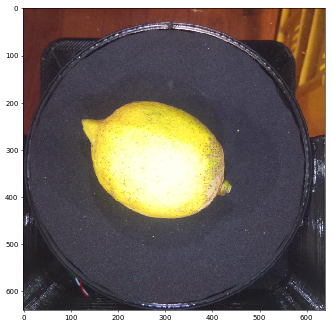

In [3]:
#---加载原始图片文件
data_files_path = "data/train_images.csv"    #原始的train_images.csv路径
fd_train_images = "data/train_images/"    #原始的训练图片文件夹路径
data_files = None    #用于加载原始图片文件
data_list = []    #数据列表
def load_data_files():
    global data_files,data_list
    data_files = pd.read_csv(data_files_path, usecols=['id','class_num'])    #dataFrame格式
    data_list = np.array(data_files)    #先转成nparray
    data_list = data_list.tolist()    #再转成list
    print(f'size of data_list:{len(data_list)}')

#---随机查看图片
def show_img_random():
    info = data_list[random.randint(0,len(data_list)-1)]    #随机获取一个图片路径
    img_file = fd_train_images+info[0]
    print(img_file)    #查看图片路径
    img_label = info[1]    #从路径中分解出标签，即图片所在的文件夹名称
    img = cv2.imread(img_file)    #用cv2打开，以输出图片形状
    print(img.shape)    #输出图片形状
    img = Image.open(img_file)    #打开图片
    print(f'label for this img:{img_label}')
    plt.figure(figsize=(8,8),dpi=50)    #修改显示的图像大小
    #plt.axis('off')
    plt.imshow(img)    #根据数组绘制图像

#---加载标签列表文件
label_list = []    #标签列表
label_dic = None    #标签字典
def load_label_txt():
    global label_list
    global label_dic
    label_list = ['0:優良', '1:良', '2:加工品', '3:規格外']
    label_dic = {'0':'優良', '1':'良', '2':'加工品', '3':'規格外'}
    print(label_dic)

load_data_files()
show_img_random()
load_label_txt()

## 3.5 对数据集进行数据量统计

[400 255 235 212]


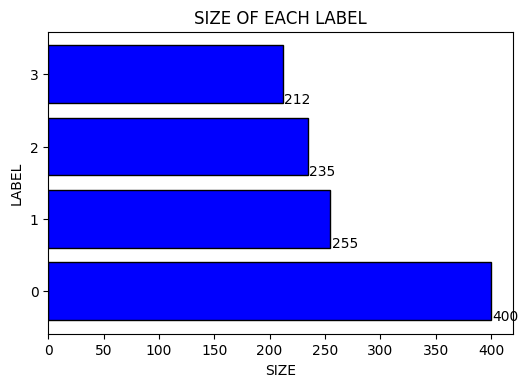

In [4]:
#--标签对应图片数据分布统计
data_label_count_list = None    #每个标签对应的图片数量统计列表
def data_label_count():
    global data_list
    global data_label_count_list
    data_label_count_list = np.zeros(len(label_list),dtype=np.int32)    #创建数据集的标签统计数组
    for info in data_list:    #遍历文件列表
        img_label = int(info[1])    #获取label
        data_label_count_list[img_label] += 1   #统计数量
        info[0] = fd_train_images+info[0]    #顺便整理文件路径,也可以使用另一种循环 for index,value in enumerate(data_list):
    print(data_label_count_list)

#---分析数据
def data_eda():
    if label_dic == None:load_label_txt()
    #matplotlib.rcParams["font.sans-serif"] = ["SimHei"]
    #matplotlib.rcParams["axes.unicode_minus"] = False
    plt.figure(dpi=100)
    plt.barh(np.arange(len(label_dic)),#每个柱子的名称
                    width=data_label_count_list,#柱子高度,即数据列表
                    height=0.8,#柱子宽度，默认为0.8
                    left=0,#柱子底部位置对应x轴的横坐标，类似bar()中的bottom         
                    align='center',#柱子名称位置，默认为'center'，可选'edge'
                    color='blue',#柱子填充色
                    edgecolor='black',#柱子外框线xian色
                    linewidth=1,#柱子外框线宽度
                    tick_label=list(label_dic.keys()),#自定义每个柱子的名称,即标签
                    #xerr=np.ones(len(label_list),dtype=np.int32)*2,#添加误差棒
                    #ecolor='red',#误差棒颜色，默认为黑色
                    #capsize=5,#误差棒上下的横线长度
                    log=False,#y轴坐标取对数       
                    )
    plt.title("SIZE OF EACH LABEL")
    plt.xlabel("SIZE")
    plt.ylabel("LABEL")
    #设置柱子上的文本,x是纵轴，y是横轴，第三个参数是文本内容
    for x,y in enumerate(data_label_count_list):
        plt.text(y+1,x-0.4,"%s"%y)
    plt.show()

data_label_count()
data_eda()

# 四、 通过数据增强，处理不平衡的数据
> * 通过上面的处理可以看到，这个数据集并不平衡，每个标签下的数据量有很大差异
> * 接下来，通过数据增强的手段，来把每个标签下的数据量拉齐
> * 使用的增强手段并不复杂，通过旋转、模糊、增加噪点来对数据进行扩充

## 通过增强处理生成的图片样例
![](https://ai-studio-static-online.cdn.bcebos.com/24439b82ddcd492d910a1dc00fbe5e398145a12555744347af5d2f9ab1fe6fd1)


## 4.1 先定义一些图片处理函数

In [5]:
#---图片统计计数函数
#img_count = 0    #图片计数
def func_counter(counter,step,func_check_point=None):    #计数函数,计数变量，步长，检查函数
    counter += step
    if func_check_point != None:func_check_point(counter)
    return counter

def check_point(num):    #计数检查函数
    if num % 500 == 0:    #每500打印一次
        print(f"check point:{num}")

#变成正方形图片
def to_cube_img(img):
    img_h = img.shape[0]    #高度
    img_w = img.shape[1]    #宽度

    if img_h == img_w:
         pass
    elif img_h > img_w:    #高大于宽，补充宽度,水平拼接
        patch_w = img_h - img_w    #计算要补充的宽度
        w_left = patch_w // 2    #左侧要补充的宽度
        w_right = patch_w - w_left    #右侧要补充的宽度
        bk_left = np.zeros((img_h,w_left,3),np.uint8)    #左侧黑边
        bk_right = np.zeros((img_h,w_right,3),np.uint8)    #右侧黑边
        img = np.hstack((bk_left,img,bk_right))    #水平拼接
    elif img_h < img_w:
        patch_h = img_w - img_h    #计算要补充的高度
        h_top = patch_h // 2    #上边要补充的高度
        h_bot = patch_h - h_top    #下边要补充的高度
        bk_top = np.zeros((h_top,img_w,3),np.uint8)    #上边的黑边
        bk_bot = np.zeros((h_bot,img_w,3),np.uint8)    #下边的黑边
        img = np.vstack((bk_top,img,bk_bot))    #垂直平拼接
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    #bgr转rgb
    return img

def img_pad(img,pads):    #随机打补丁
    """
    对图片添加随机颜色、随机大小的色块
    传入RGB格式图片
    """
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
    h = img.shape[0]    #图片高
    w = img.shape[1]    #图片宽
    
    for i in range(pads):    #打补丁的次数
        h_pad = h//5    #补丁最大高度
        w_pad = w//5    #补丁最大宽度
        if h_pad > 5:h_pad = random.randint(5,h_pad)    #随机生成一个高度
        if w_pad > 5:w_pad = random.randint(5,w_pad)    #随机生成宽度
        h_pad_begin = random.randint(0,h-h_pad-1)    #随机生成补丁左上角h坐标值
        w_pad_begin = random.randint(0,w-w_pad-1)    #随机生成补丁左上角w坐标值
        img[h_pad_begin:h_pad_begin+h_pad,w_pad_begin:w_pad_begin+w_pad] = np.random.randint(0,255,3)   #打补丁
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
    return img

def make_fake_image(img_path,    #原图片路径
                    fake_image_path,    #新图片路径
                    hf=True,    #水平翻转
                    vf=False,    #垂直翻转
                    pads=0,    #打补丁的次数
                    rot=False,    #旋转
                    gs=False    #高斯滤波
                    ):
    """
    生成一个新图片，并保存
    传入原图片路径（含文件名）、新图片路径（含文件名）
    """
    img = cv2.imread(img_path)    #读取原始图片
    img = to_cube_img(img)    #转成正方形
    img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))    #转pil格式图片
    if hf:
        img = F.hflip(img)    #水平翻转
    if vf:
        img = F.vflip(img)    #垂直翻转
    if pads>0:
        img = img_pad(img,pads=pads)    #打补丁
    if rot:
        transform = RandomRotation((10,90))    #旋转10~90度
        img = transform(img)    #随机旋转
    if gs:
        img = cv2.GaussianBlur(img,(5,5),0,0)
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
    cv2.imwrite(fake_image_path,img)    #保存生成的图片
    return img

## 4.2 分割出训练集和验证集

In [6]:
#---分割训练集和验证集
train_list = None   #训练集列表
eval_list = None   #验证集列表
def split_train_eval(): 
    global train_list
    global eval_list
    random.shuffle(data_list)    #对所有数据文件列表进行乱序处理
    all_size = len(data_list)    #所有文件总数
    train_size = int(all_size * 0.8)    #训练集大小
    train_list = data_list[:train_size]    #分割训练集
    eval_list = data_list[train_size:]    #分割验证集
    print(f"length of train_list:{len(train_list)}")
    print(f"length of eval_list:{len(eval_list)}")
    print(train_list[1])

split_train_eval()

length of train_list:881
length of eval_list:221
['data/train_images/train_0595.jpg', 3]


## 4.3 整理训练集数据，对齐各个标签的数据量

In [7]:
#---统计各个标签对应的图片数量
train_label_count_list = None    #训练集每个标签对应的图片数量统计
train_list_by_label = []    #分离各个标签对应的图片列表
def train_label_count():
    global train_label_count_list
    global train_list_by_label
    train_label_count_list = np.zeros(len(label_list),dtype=np.int32)    #创建训练集的标签统计数组
    train_list_by_label = []    #分离各个标签对应的图片列表
    for i in range(0,len(train_label_count_list)):    #初始化一个空列表，准备填充数据
        train_list_by_label.append([])

    for tline in train_list:    #遍历原始训练集列表
        train_label_count_list[tline[1]] += 1    #统计各个标签对应的图片数量
        train_list_by_label[tline[1]].append(tline)    #把数据信息添加到对应列表
    print(f"size of eache label:{train_label_count_list}")

#---整理训练集数据，对齐各个标签的图片数量
fd_fake_train_images = "fake_train_images/"    #扩增的训练图片文件夹路径
new_train_list = []    #新的训练集列表
def label_img_align(align=True):
    global new_train_list
    
    new_train_list_by_label = []    #新的训练集图片列表,其中每一个子列表就是一个标签下的图片
    num_target = train_label_count_list[np.argmax(train_label_count_list)]    #取图片数量最大值
    if(os.path.exists(fd_fake_train_images[:-1])):shutil.rmtree(fd_fake_train_images[:-1])    #删除上次生成的文件
    os.mkdir(fd_fake_train_images[:-1])    #创建目录
    if align == False:
        new_train_list = train_list
        return
    for imglist in train_list_by_label:    #通过对原始图片进行变形以生成新图片，使每个标签下的图片数量一致
        img_num = num_target-len(imglist)    #要创建的图片数量
        img_tmp_list = []    #用于保存每个标签对应的图片集
        img_tmp_list.extend(imglist)    #把原始图片加入列表
        while img_num > 0:
           for tline in imglist:
                img_path = tline[0]    #原始图片路径
                img_label = tline[1]    #图片标签
                file_name = img_path.split("/")[-1]    #取出文件名
                fake_file_name = str(img_label)+"_"+str(img_num)+"_"+file_name    #新的文件名
                fake_img_path = fd_fake_train_images+fake_file_name    #生成的图片路径
                make_fake_image(img_path,fake_img_path,hf=True,vf=False,pads=3,rot=False,gs=False)    #生成新图片
                img_tmp_list.append([fake_img_path,tline[1]])    #将生成的图片和标签添加到列表
                img_num -= 1    #计数器减小1
                if img_num == 0:break
        new_train_list_by_label.append(img_tmp_list)


    for imglist in new_train_list_by_label:
        new_train_list.extend(imglist)    #组织新的训练集列表

    random.shuffle(new_train_list)  #乱序
    #print(new_train_list)
    print(f"length of new_train_list:{len(new_train_list)}")
    i = 0
    for lst in new_train_list_by_label:
        print(f"size of label [{i}]:{len(lst)} ")
        i += 1

train_label_count()
label_img_align(True)

size of eache label:[328 202 184 167]
length of new_train_list:1312
size of label [0]:328 
size of label [1]:328 
size of label [2]:328 
size of label [3]:328 


## 4.4 保存训练集和验证集

In [8]:
#---txt文件路径
train_list_txt = "train_list.txt"    #原始训练集
all_train_set_txt = "all_train_set.txt"    #最终版本的训练集文件路径
train_set_txt = "train_set.txt"    #训练集txt文件路径,原始分割的训练集
validation_set_txt = "validation_set.txt"    #验证集txt文件路径
test_set_txt = "test_set.txt"    #测试集txt文件路径

#---保存训练集和验证集
def write_list_to_file(img_list,file_path,patch=""):
    if os.path.exists(file_path):os.remove(file_path)    #删除已有的文件
    count = 0 
    with open(file_path, 'a')as f:
        for tline in img_list:
            f.write(patch+tline[0]+"#"+str(tline[1])+"\n")
            count += 1
    print(f"{count} lines in file {file_path}")
    print(f"file {file_path} has been created")

def save_train_eval_txt():
    write_list_to_file(train_list,train_list_txt)    #保存原始训练集
    write_list_to_file(new_train_list,train_set_txt)    #写入训练集记录文件
    write_list_to_file(eval_list,validation_set_txt)    #写入验证集记录文件
    if(os.path.exists(all_train_set_txt)):os.remove(all_train_set_txt)    #清理文件，为后面操作做准备

save_train_eval_txt()

881 lines in file train_list.txt
file train_list.txt has been created
1312 lines in file train_set.txt
file train_set.txt has been created
221 lines in file validation_set.txt
file validation_set.txt has been created


## 4.5 倍增训练集（可选）
> * 如果觉得数据量不够，还可以利用数据增强手段扩增数据集

## 4.6 计算均值和标准差

In [9]:
#---准备计算各通道的均值与标准差
img_h, img_w = 224, 224   #根据自己数据集适当调整，影响不大
means, stdevs = [], []   #各通道均值和标准差
means_stdevs_txt = "means_stdevs.txt"    #均值和标准差保存文件

#---打印各通道均值和标准差
def print_means_stdevs():
    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))

#---从set记录文件读入图片信息，然后对bgr各通道求和，返回计算结果和像素计数
def bgr_sum(set_txt):
    bgr_sum = np.zeros(3)    #各通道求和
    pixels_count = 0    #像素点总数
    img_count = 0    #计数
    with open(set_txt) as f:
        for tline in f:
            info = tline.split("#")    #分离数据
            img_path = info[0]    #取出图片地址
            img = cv2.imread(img_path)    #读取地址
            #print(img.shape)
            img = cv2.resize(img,(img_h,img_w))    #缩放
            pixels_count += img.shape[0]*img.shape[1]    #累计像素总数
            bgr = img.transpose(2,0,1)    #转成bgr三通道矩阵
            #print(bgr.shape)
            bgr_sum += np.sum(bgr/255,axis=(1,2))    #各通道归一化，然后求和
            img_count = func_counter(img_count,1,check_point)    #图片计数
            #print(bgr_sum.shape)
            #print(bgr_sum)
            #break
    print(f"image count:{img_count}")
    return (bgr_sum,pixels_count)

#---从set记录文件读入图片信息，然后根据传入的均值，各像素减均值，再求平方和，返回计算结果和像素计数
def bgr_sum_sq(set_txt,means):
    bgr_sum = np.zeros(3)    #各通道求和
    pixels_count = 0    #像素点总数
    img_count = 0    #计数
    with open(set_txt) as f:
        for tline in f:
            info = tline.split("#")    #分离数据
            img_path = info[0]    #取出图片地址
            img = cv2.imread(img_path)    #读取地址
            #print(img.shape)
            img = cv2.resize(img,(img_h,img_w))    #缩放
            pixels_count += img.shape[0]*img.shape[1]    #累计像素总数
            bgr = img.transpose(2,0,1)    #转成bgr三通道矩阵
            bgr = bgr.reshape(3,-1)    #转成二维
            bgr = bgr/255    #归一化
            for i in range(bgr.shape[0]):
                bgr[i] -= means[i]    #各个通道像素减均值
            bgr = bgr**2    #平方
            bgr_sum += np.sum(bgr,axis=1)    #平方和
            img_count = func_counter(img_count,1,check_point)    #图片计数
            #print(bgr.shape)
            #print(bgr)
            #break
    print(f"image count:{img_count}")
    return (bgr_sum,pixels_count)

#---计算各通道均值和标准差
def calc_means_stdevs():

    global means, stdevs
    if(os.path.exists(means_stdevs_txt)):os.remove(means_stdevs_txt) #删除已有的文件
    set_txt_files = []    #数据集txt文件列表
    #set_txt_files.append(all_train_set_txt)
    set_txt_files.append(train_set_txt)
    set_txt_files.append(validation_set_txt)
    #计算均值
    sum = 0
    count = 0
    for set_txt in set_txt_files:
        sum1,count1 = bgr_sum(set_txt)
        sum += sum1
        count += count1
    means = sum / count    #均值
    #计算标准差
    sum = 0
    count = 0
    for set_txt in set_txt_files:
        sum1,count1 = bgr_sum_sq(set_txt,means)
        sum += sum1
        count += count1
    stdevs = sum / count    #方差
    stdevs = np.sqrt(stdevs)    #标准差

    #BGR --> RGB,CV读取的需要转换，PIL读取的不用转换
    means = means[::-1]
    stdevs = stdevs[::-1]

    with open(means_stdevs_txt, 'a')as f:
        tline = "means="+str(means.tolist())+"\n"
        f.write(tline)
        tline = "stdevs="+str(stdevs.tolist())
        f.write(tline)
    print_means_stdevs()


#---从文件读取均值和标准差
def load_means_stdevs():
    global means,stdevs
    with open(means_stdevs_txt) as f:    #读取集数据
        for tline in f:
            info =tline.strip().split("=")
            data = info[1][1:-1].split(",")
            for i in range(0,3):
                data[i] = float(data[i].strip())
            if info[0] == "means":
                means = data
            else:
                stdevs = data
    print_means_stdevs()

calc_means_stdevs()

check point:500
check point:1000
image count:1312
image count:221
check point:500
check point:1000
image count:1312
image count:221
normMean = [0.30920847 0.25227575 0.12478764]
normStd = [0.33604946 0.2951188  0.14170679]


# 五、 数据集类定义

In [10]:
#---自定义数据读取器
class ImageSetReader(Dataset):
    def __init__(self,
                means,    #均值
                stdevs,    #标准差
                mode='train_set'):
        """
        初始化函数
        """
        self.mode = mode
        self.data = []
        with open(mode+".txt") as f:
            for line in f.readlines():
                info = line.strip().split('#')
                if len(info) > 0:
                    self.data.append([info[0].strip(), info[1].strip()])
        self.data_transforms = ImageSetReader.image_transforms(means,stdevs)

        print(f"size of {mode}:{len(self.data)}")
                      
    def __getitem__(self, index):
        """
        读取图片，对图片进行归一化处理，返回图片和 标签
        """
        image_file, label = self.data[index]  # 获取数据
        #img = ImageSetReader.load_image(image_file)    # 读取图片
        img = Image.open(image_file).convert('RGB')
        
        #return img, np.array(label, dtype='int64')
        return self.data_transforms(img), np.array(label, dtype='int64')

    @staticmethod
    def image_transforms(means,stdevs):
        data_transforms = transforms.Compose([
                                transforms.Resize(size=(img_h,img_w)),
                                transforms.Transpose(),
                                #transforms.Normalize(      #像素值归一化
                                #mean=[0, 0, 0],    #均值
                                #std=[255, 255, 255]),    #标准差
                                #transforms.ToTensor(), # transpose操作 + (img / 255),并且数据结构变为PaddleTensor
                                transforms.Normalize(      #减均值 除标准差
                                mean=means,
                                std=stdevs)
                                #计算过程：output[channel] = (input[channel] - mean[channel]) / std[channel]
                                ])
        return data_transforms

    @staticmethod
    def load_image(image_file,means,stdevs):
        """
        读取图片，对图片进行归一化处理，返回图片
        """
        img = Image.open(image_file)    #打开图片文件
        return ImageSetReader.image_transforms(means,stdevs)(img)

    @classmethod
    def load_image_4d(cls,image_file,means,stdevs):
        """
        读取图片，对图片进行归一化处理，扩展维度，返回图片
        """
        img = cls.load_image(image_file,means,stdevs)    #读取图片
        img = np.expand_dims(img, axis=0)    #扩展一个维度
        return img

    def __len__(self):
        """
        获取样本总数
        """
        return len(self.data)


# 六、模型组网
> * 作为示例，这里面使用框架提供的算子组建了一个很简单的网络。

## 6.1 定义网络模型

In [11]:
#---构造模型
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=4, model_name="model_mk0"):    #输出的分类数，模型名称
        super(MyNet, self).__init__()
        self.model_name = model_name

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=224, kernel_size=(3, 3), stride=1, padding = 1)
        #self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.relu1=paddle.nn.ReLU()
        
        self.conv2 = paddle.nn.Conv2D(in_channels=224, out_channels=224, kernel_size=(3,3),  stride=2, padding = 0)
        #self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.relu2=paddle.nn.ReLU()
        
        #self.conv3 = paddle.nn.Conv2D(in_channels=224, out_channels=224, kernel_size=(3,3), stride=2, padding = 0)
        #self.relu3=paddle.nn.ReLU()
        
        #self.conv4 = paddle.nn.Conv2D(in_channels=224, out_channels=224, kernel_size=(3,3), stride=2, padding = 1)
        #self.pool4 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        #self.relu4=paddle.nn.ReLU()
        self.flatten = paddle.nn.Flatten()
        
        self.linear1 = paddle.nn.Linear(in_features=2759904, out_features=224)
        #self.linear1 = paddle.nn.Linear(in_features=175616, out_features=224)
        self.relu5=paddle.nn.ReLU()
        self.linear2 = paddle.nn.Linear(in_features=224, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.pool1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        #x = self.conv3(x)
        #x = self.relu3(x)
        
        #x = self.conv4(x)
        #x = self.pool4(x)
        #x = self.relu4(x)
        x = self.flatten(x)
        
        x = self.linear1(x)
        x = self.relu5(x)
        x = self.linear2(x)
        return x

## 6.2 封装模型

In [12]:
#---封装模型

model = None    #封装好的模型
def build_model(my_net,model_name):
    input = InputSpec([1, 3, 224, 224], 'float32', 'x')
    #label = InputSpec([None, 1], 'int64', 'label')
    model = paddle.Model(my_net(num_classes=len(label_dic),model_name=model_name),input)
    print(f"model name:{model.network.model_name}")
    model.summary((1, 3, 224, 224))
    return model

model = build_model(MyNet,"lemon4_mk1")


W0218 10:33:59.574426  1503 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0218 10:33:59.579174  1503 device_context.cc:422] device: 0, cuDNN Version: 7.6.


model name:lemon4_mk1
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 3, 224, 224]]   [1, 224, 224, 224]       6,272     
    ReLU-1      [[1, 224, 224, 224]]  [1, 224, 224, 224]         0       
   Conv2D-2     [[1, 224, 224, 224]]  [1, 224, 111, 111]      451,808    
    ReLU-2      [[1, 224, 111, 111]]  [1, 224, 111, 111]         0       
   Flatten-1    [[1, 224, 111, 111]]     [1, 2759904]            0       
   Linear-1        [[1, 2759904]]          [1, 224]         618,218,720  
    ReLU-3           [[1, 224]]            [1, 224]              0       
   Linear-2          [[1, 224]]             [1, 4]              900      
Total params: 618,677,700
Trainable params: 618,677,700
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 234.67
Params size (MB): 

## 6.3 作为对比，封装第二个模型

In [13]:
model1 = build_model(MyNet,"lemon4_mk2")

model name:lemon4_mk2
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-3      [[1, 3, 224, 224]]   [1, 224, 224, 224]       6,272     
    ReLU-4      [[1, 224, 224, 224]]  [1, 224, 224, 224]         0       
   Conv2D-4     [[1, 224, 224, 224]]  [1, 224, 111, 111]      451,808    
    ReLU-5      [[1, 224, 111, 111]]  [1, 224, 111, 111]         0       
   Flatten-3    [[1, 224, 111, 111]]     [1, 2759904]            0       
   Linear-3        [[1, 2759904]]          [1, 224]         618,218,720  
    ReLU-6           [[1, 224]]            [1, 224]              0       
   Linear-4          [[1, 224]]             [1, 4]              900      
Total params: 618,677,700
Trainable params: 618,677,700
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 234.67
Params size (MB): 

# 七、模型训练
> * 作为对比，可将此处的 train_set.txt 换成 未经处理的原始训练集 train_list.txt，然后重新训练一次

## 7.1 加载数据

In [18]:
#---生成数据加载器
def make_data_set_reader(mode='all_train_set'):
    return ImageSetReader(means,stdevs,mode=mode)

#---准备数据集读取器
train_dataset = None    #训练集数据加载器
eval_dataset = None    #评估集数据加载器
train_list_dataset = None    #未经处理的原始训练集

#---生成数据集加载器
def prepare_dataset_all():
    global train_dataset    #训练集数据加载器
    global eval_dataset    #评估集数据加载器
    global train_list_dataset    #

    #train_dataset = make_data_set_reader(all_train_set_txt.split(".")[0])
    train_dataset = make_data_set_reader(train_set_txt.split(".")[0])
    eval_dataset = make_data_set_reader(validation_set_txt.split(".")[0])
    train_list_dataset = make_data_set_reader(train_list_txt.split(".")[0])

    print(f'size of train_dataset:{train_dataset.__len__()}')
    print(f'size of eval_dataset:{eval_dataset.__len__()}')

    # 查看图片数据、大小及标签
    print("sample of eval_dataset:")
    for data, label in eval_dataset:
        print(f"data label:{label}")
        print(f"data shape:{np.array(data).shape}")
        print(f"data content:\n{data}")
        break

prepare_dataset_all()

size of train_set:1312
size of validation_set:221
size of train_list:881
size of train_dataset:1312
size of eval_dataset:221
sample of eval_dataset:
data label:2
data shape:(3, 224, 224)
data content:
[[[144.89174  147.8675   141.91599  ...  61.570675  58.59492   61.570675]
  [147.8675   150.84325  147.8675   ...  67.52218   64.546425  67.52218 ]
  [150.84325  153.819    150.84325  ...  64.546425  61.570675  64.546425]
  ...
  [ 46.69191   49.667664  79.425186 ... 180.60077  109.18271   94.30395 ]
  [ 61.570675  76.44943   79.425186 ... 171.67351   76.44943   79.425186]
  [ 88.35245   91.32819  121.085724 ...  76.44943   64.546425  91.32819 ]]

 [[ 49.97216   53.360626  46.583694 ...  29.641365  26.2529    29.641365]
  [ 53.360626  56.749092  53.360626 ...  36.418297  33.02983   36.418297]
  [ 56.749092  60.137558  56.749092 ...  33.02983   29.641365  33.02983 ]
  ...
  [ 49.97216   53.360626  87.245285 ... 209.23004  131.29533  114.353004]
  [ 66.91449   83.85682   87.245285 ... 202.4

## 7.2 定义训练函数

In [15]:
fd_visualdl_log = "fd_visualdl_log"
def model_train(model,    #要训练的模型
                train_set,    #训练集
                val_set,    #验证集
                epochs=1,    #训练轮次
                batch_size=6,    #批次大小
                lr=3e-4,    #学习率
                ):

    #定义优化器
    optim = paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters())

    #配置优化器、损失函数、评估指标
    model.prepare(optim, 
              paddle.nn.CrossEntropyLoss(), 
              paddle.metric.Accuracy())

    
    if os.path.exists(fd_visualdl_log):shutil.rmtree(fd_visualdl_log)    #visualdl_log文件夹 
    visualdl = paddle.callbacks.VisualDL(log_dir=fd_visualdl_log)   #训练可视化VisualDL工具的回调函数

    #启动模型全流程训练
    model.fit(train_set,    # 训练数据集
            val_set,    # 评估数据集
            epochs=epochs,    # 训练的总轮次,30,50是比较理想的设置
            batch_size=batch_size,    # 训练使用的批大小,使用变动学习率时，batch_size最好小一些，6，8
            verbose=1,    # 日志展示形式
            callbacks=[visualdl])    # 设置可视化


## 7.3 训练模型

In [16]:
model_train(model,
        train_dataset,
        eval_dataset,
        epochs=5,    #训练轮次
        batch_size=16,    #批次大小
        lr=5e-5    #学习率
        )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 82/82 [==============================] - loss: 78.4950 - acc: 0.7035 - 158ms/step           
Eval begin...
step 14/14 [==============================] - loss: 787.1945 - acc: 0.7692 - 138ms/step          
Eval samples: 221
Epoch 2/5
step 82/82 [==============================] - loss: 128.5948 - acc: 0.8963 - 143ms/step         
Eval begin...
step 14/14 [==============================] - loss: 581.2987 - acc: 0.8643 - 139ms/step          
Eval samples: 221
Epoch 3/5
step 82/82 [==============================] - loss: 0.0000e+00 - acc: 0.9505 - 143ms/step          
Eval begin...
step 14/14 [==============================] - loss: 36.7712 - acc: 0.9819 - 146ms/step             
Eval samples: 221
Epoch 4/5
step 82/82 [==============================] - loss: 0.0000e+00 - acc: 0.9672 - 145ms/step          
Eval begin...
step 14/14 [==============================] - loss: 56.9460 - acc: 0.9819 - 139ms/step             
Eval samples: 221
Epoch 5/5
step 82/82 [=============================

## 7.4 作为对比，训练第二个模型

In [19]:
model_train(model1,
        train_list_dataset,
        eval_dataset,
        epochs=5,    #训练轮次
        batch_size=16,    #批次大小
        lr=5e-5    #学习率
        )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5
step 56/56 [==============================] - loss: 0.0000e+00 - acc: 0.6686 - 163ms/step         
Eval begin...
step 14/14 [==============================] - loss: 1402.3003 - acc: 0.7919 - 147ms/step         
Eval samples: 221
Epoch 2/5
step 56/56 [==============================] - loss: 0.0000e+00 - acc: 0.9103 - 152ms/step       
Eval begin...
step 14/14 [==============================] - loss: 102.5101 - acc: 0.9321 - 139ms/step            
Eval samples: 221
Epoch 3/5
step 56/56 [==============================] - loss: 0.0000e+00 - acc: 0.9784 - 140ms/step        
Eval begin...
step 14/14 [==============================] - loss: 1.9988 - acc: 0.9864 - 158ms/step              
Eval samples: 221
Epoch 4/5
step 56/56 [==============================] - loss: 0.0000e+00 - acc: 0.9886 - 165ms/step          
Eval begin...
step 14/14 [==============================] - lo

# 八、 评估模型
> * 这里可以明显看出，使用处理过的数据集可以有效提升训练效果

In [22]:
#---模型评估
def model_eval(model,eval_dataset):
    print(f"model {model.network.model_name}:")
    result = model.evaluate(eval_dataset, verbose=1)
    print(result)
model_eval(model,eval_dataset)
model_eval(model1,eval_dataset)

model lemon4_mk1:
Eval begin...
step 221/221 [==============================] - loss: 0.0000e+00 - acc: 0.9819 - 10ms/step          
Eval samples: 221
{'loss': [0.0], 'acc': 0.9819004524886877}
model lemon4_mk2:
Eval begin...
step 221/221 [==============================] - loss: 0.0000e+00 - acc: 0.9729 - 9ms/step          
Eval samples: 221
{'loss': [0.0], 'acc': 0.9728506787330317}


# 九、保存模型

In [23]:
#---保存模型参数
fd_model_save = "model_save/"    #模型保存目录
def model_save(model):
    if os.path.exists(fd_model_save[:-1]):shutil.rmtree(fd_model_save[:-1])    #保存模型的文件夹
    print(f"saving model {model.network.model_name} for training...")
    model.save(fd_model_save+model.network.model_name)  # save for training
    print(f"saving model {model.network.model_name} for inference...")
    model.save(fd_model_save+model.network.model_name, False)  # save for inference
    print(f"model {model.network.model_name} has been saved")
model_save(model)
#model_save(model1)

saving model lemon4_mk1 for training...
saving model lemon4_mk1 for inference...
model lemon4_mk1 has been saved


# 十、模型预测



## 10.1 定义预测函数

In [25]:
#---模型预测函数，传入图片路径
def model_predict(my_net,model_name,img_path):
    #paddle.set_device('gpu:1')
    #paddle.set_device('cpu')
    #定制化模型（无需label）
    input_define = paddle.static.InputSpec(shape=[1,3,224,224], dtype="float32", name="img")
    model = paddle.Model(my_net(num_classes=len(label_dic),model_name=model_name),input_define)
    #加载模型参数
    model.load(fd_model_save+model.network.model_name)
    model.prepare()
    img = ImageSetReader.load_image_4d(img_path,means,stdevs)    #加载图片,并扩展维度
    result = model.predict(test_data=[img])
    #print(result)
    #idx = np.argmax(result)
    #print(f"result:[{label_list[idx]}]")
    return result

## 10.2 模型预测测试

image file:data/train_images/train_0001.jpg
image label_index:0
image label:0:優良
Predict begin...
step 1/1 [==============================] - 7ms/step
Predict samples: 1
[(array([[ -2416.206, -10394.781, -10640.406,  -5842.354]], dtype=float32),)]
result:[0:優良]


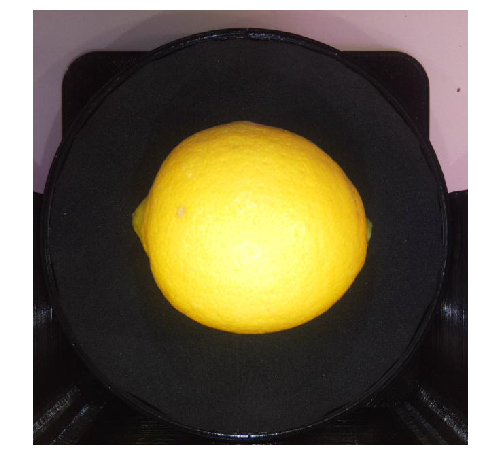

In [26]:
# ---模型预测测试
def predict_test():
    #从验证集中随机抽取一张图片
    idx = random.randint(0,eval_dataset.__len__())
    img_label = eval_dataset.data[idx][1]
    img_path = eval_dataset.data[idx][0]    #图片文件路径
    print(f"image file:{img_path}")    #图片路径
    print(f"image label_index:{img_label}")    #标签索引
    print(f"image label:{label_list[int(img_label)]}")    #图片标签

    #显示图片
    plt.figure(figsize=(8,8),dpi=72)  # 修改显示的图像大小
    plt.axis('off')
    plt.imshow(Image.open(img_path))

    #用模型预测选取的图片，并打印输出预测结果
    result = model_predict(MyNet,"lemon4_mk1",img_path)
    print(result)
    idx = np.argmax(result)
    print(f"result:[{label_list[idx]}]")
predict_test()

# 十一、清理文件

In [28]:
#---清理生成的所有文件
def clean_all_files():
    if os.path.exists(fd_fake_train_images[:-1]):shutil.rmtree(fd_fake_train_images[:-1])    #fake_train_images文件夹
    if os.path.exists(fd_model_save[:-1]):shutil.rmtree(fd_model_save[:-1])    #保存模型的文件夹
    if os.path.exists(fd_visualdl_log):shutil.rmtree(fd_visualdl_log)    #visualdl_log文件夹 
    if os.path.exists(train_list_txt):os.remove(train_list_txt)    #未经处理的训练集
    if os.path.exists(all_train_set_txt):os.remove(all_train_set_txt)    #最终的训练集
    if os.path.exists(train_set_txt):os.remove(train_set_txt)    #最初划分的训练集
    if os.path.exists(validation_set_txt):os.remove(validation_set_txt)    #验证集
    if os.path.exists(means_stdevs_txt):os.remove(means_stdevs_txt)    #均值和标准差
    #tmp_file = "tmp_"+all_train_set_txt    #扩增数据集时使用的临时文件
    #if os.path.exists(tmp_file):os.remove(tmp_file)
clean_all_files()



# 十二、 总结

> * 如评估结果所示，使用增强处理手段，把标签数量拉齐，和不经过处理直接训练，训练的结果是不同的。
> * ![](https://ai-studio-static-online.cdn.bcebos.com/5d341ee9795b4cd69b64c7bc0c17bb8a54a245938e344e7b9791f69b04090358)
> * 即便是很简单的图片处理手段，通过合成新的数据，拉齐标签数量，也有利于提升训练效果